In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path + scenario + '/'):
    os.makedirs(output_path + scenario + '/')

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [7]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [8]:
sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [12]:
# Load volumes
volumes_file = 'de_volumes'
v = stepmodel.read_json(model_path + scenario + '/' + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

In [13]:
# Load LoS tables with mode choice probabilities
car = stepmodel.read_json(model_path + scenario + '/' + 'de_road_los')
pt = stepmodel.read_json(model_path + scenario + '/' + 'de_pt_los')

In [14]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) for col in pt.pt_los.columns if 'probability' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [15]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [16]:
sm.pt_los.sample(2)

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
index,,,,,,,,,,,,,,,,,,,,,
186162,DE279,DEA2D,"[bus, rail_short, air]","(rs_36757, rs_45104, rs_45105, rs_45106, rs_39...",7,915494,1769,1487,15940,10040,...,0.000004,0.000063,2.000000e-09,8.914000e-07,0.008017,0.000525,0.000003,0.003423,0.000000,2.400000e-09
522491,DEG04,DE21J,"[coach, bus]","(bus_727263, c_1871, c_1872, c_1873, c_1874, c...",4,260096,1650,76,14220,12000,...,0.081986,0.006436,2.989008e-01,1.505176e-01,0.214472,0.008174,0.127349,0.017843,0.004206,1.536283e-03


In [17]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

## Assignment

The current volumes table contains outward and return trips per OD pair.

In [18]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

accompany_car: 100%|███████████████████████████████████████████████████████████████████| 12/12 [04:43<00:00, 23.67s/it]


In [19]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

accompany_car: 100%|███████████████████████████████████████████████████████████████████| 12/12 [05:55<00:00, 29.64s/it]


In [20]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [21]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway,"(load, bus)","(load, rail)","(load, air)","(load, walk)",load
index,,,,,,,,,,,,,,,
rs_39968,rail_short,rail_short,"LINESTRING (9.29032 49.43244, 9.27885 49.41692)",rs_DE127_20,rs_DE127_24,5,rs_31,120,rs_31_72,43200,0.0,73824.532828,0.0,0,73824.532828


In [22]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,maxspeed,length,time,geometry,lanes,"(commuting_no_car, car)","(commuting_car, car)","(business_no_car, car)","(business_car, car)","(education_no_car, car)","(education_car, car)","(buy/execute_no_car, car)","(buy/execute_car, car)","(leisure_no_car, car)","(leisure_car, car)","(accompany_no_car, car)","(accompany_car, car)","(all, car)"
index,,,,,,,,,,,,,,,,,,,,
rl_397955,56314000,56314017,50,217,15,"LINESTRING (8.04931 52.27823, 8.05036 52.27638)",4,296.612311,1.493391e+06,800.247281,2.183703e+06,23.115429,102535.784525,3109.872868,1.127072e+06,1695.159275,3.337159e+06,0.208534,834250.02228,9.084036e+06


In [23]:
sm.los.sample()

,index,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,...,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car,volume
125408,125408,DE244,DE947,"[bus, rail_short, air]","(rs_43569, rs_43570, rs_43571, rs_43572, rs_43...",6.0,712039,1633,1037,16220,...,0.012227,0.0,0.0,0.0,0.0,0.00086,1.878269,1.110594e-09,0.000002,1.891408


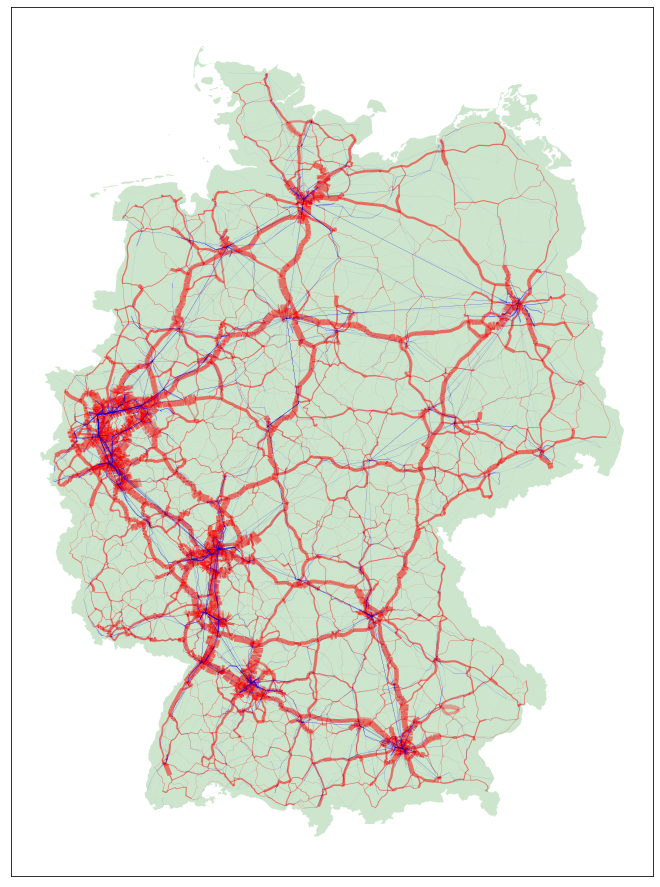

In [24]:
# Plot road and PT assignment
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))
plt.savefig(output_path + scenario + '/' + 'network_load_all.png', dpi=300)

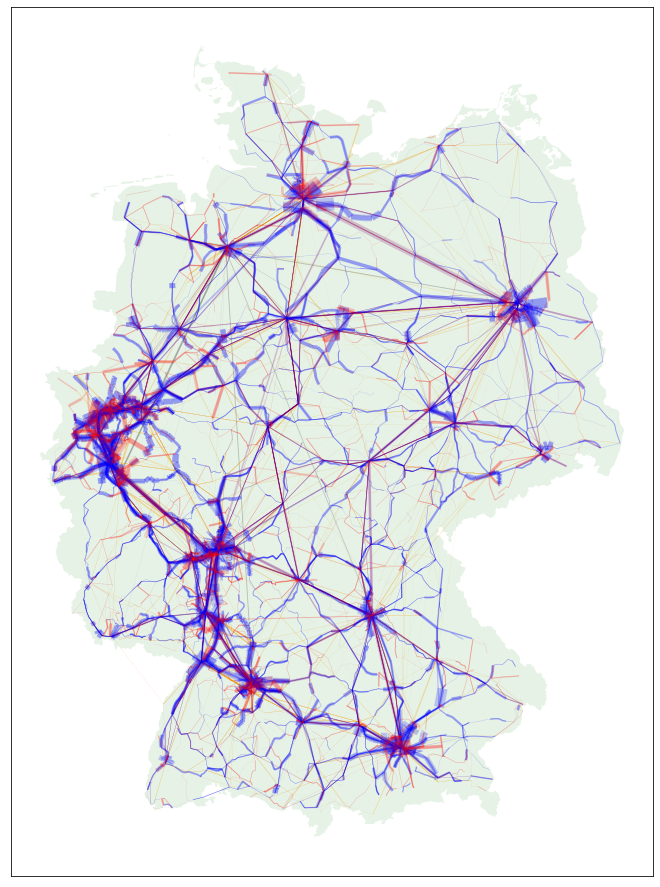

In [25]:
# Only PT
colors = sm.loaded_links['route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.loaded_links.plot(alpha=.2, color=list(colors),
    linewidth=list(sm.loaded_links['load']/sm.loaded_links['load'].max()*35),
    ax=sm.plot('zones', alpha=.1, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_pt.png', dpi=300)

### Validation

In [26]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

<AxesSubplot:>

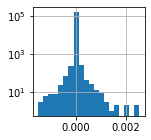

In [28]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [70]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments].sum()
for purpose in purposes:
    od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg.split('_')[0]==purpose]].sum(axis=1)
od_sum.drop(sm.segments, axis=1, inplace=True)
od_sum['root'] = od_sum.sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [71]:
od_sum.sample()

,,segment,commuting,business,education,buy/execute,leisure,accompany,root
,,sum,volume,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,,
DE923,DEF06,bus,0.0,40.152253,0.0,0.0,399.268739,8.745149,448.166142


In [72]:
# Add averages from following attributes
attrs = ['time', # hours per trip
         'in_vehicle_time', # seconds per ride
         'waiting_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type']).mean()[attrs]
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [73]:
# Convert units
od_sum[('root', 'length')] /= 1000
od_sum[('root', 'in_vehicle_time')] /= 3600
od_sum[('root', 'waiting_time')] /= 3600

In [74]:
# Compute passenger kilometer
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [75]:
# Load calibration dataset for modal split validation
mid2017 = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid2017.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_agg'] = [mode_dict_mid[i] for i in mid2017.index]

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>, <AxesSubplot:ylabel='4'>,
       <AxesSubplot:ylabel='6'>], dtype=object)

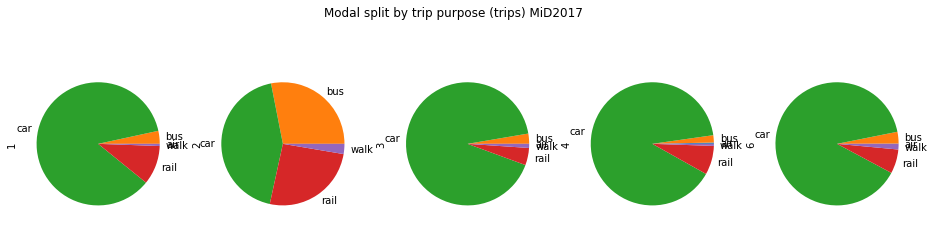

In [76]:
mid2017.groupby('mode_agg').sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

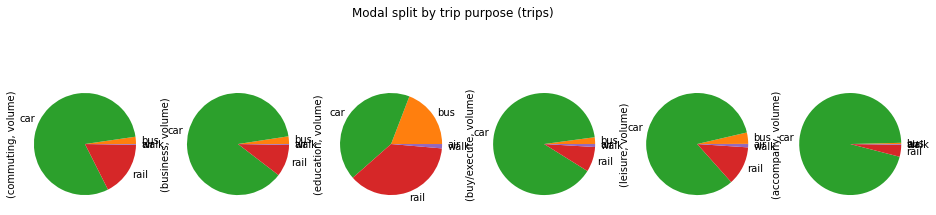

In [77]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [93]:
# MiD mode shares in percent
(mid2017.groupby('mode_agg').sum() / mid2017[['1','4','2','3','6']].sum() * 100)[['1','4','2','3','6']].round(2)

,1,4,2,3,6
mode_agg,,,,,
air,0.00,0.35,0.00,0.01,0.05
bus,3.40,1.90,28.10,2.67,3.10
car,85.75,89.62,43.49,91.72,89.03
rail,10.28,7.59,25.75,4.53,6.34
walk,0.57,0.54,2.66,1.08,1.48


In [91]:
# Model mode shares in percent
(od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum() /
 od_sum[[(seg, 'volume') for seg in purposes]].sum() * 100).round(2)

segment,commuting,business,education,buy/execute,leisure,accompany
sum,volume,volume,volume,volume,volume,volume
mode,,,,,,
air,0.00,0.00,0.00,0.00,0.05,0.00
bus,2.30,2.43,19.16,2.13,3.59,0.38
car,80.14,87.15,42.33,88.99,82.96,95.60
rail,17.31,10.14,37.13,7.94,12.35,3.77
walk,0.25,0.28,1.37,0.94,1.05,0.24


In [37]:
# MiD2017 mode shares - total
mid2017['sum'] = mid2017[['1','2','3','4','6']].sum(axis=1)
(mid2017.groupby('mode_agg').agg({'sum': 'sum'}) / mid2017['sum'].sum() * 100).round(2)

,sum
mode_agg,
air,0.04
bus,3.99
car,87.05
rail,7.79
walk,1.13


In [94]:
# Model mode shares in percent - total
(od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2)

sum,volume,time,in_vehicle_time,waiting_time,length,ntransfers,pkm
mode,,,,,,,
air,0.01,7.53,5.78,14.26,9.57,16.26,0.12
bus,3.31,33.26,30.39,47.34,22.42,40.20,2.85
car,82.71,26.01,32.99,0.00,33.93,0.00,86.46
rail,13.31,33.04,30.83,38.40,34.04,43.54,10.33
walk,0.65,0.15,0.00,0.00,0.04,0.00,0.25


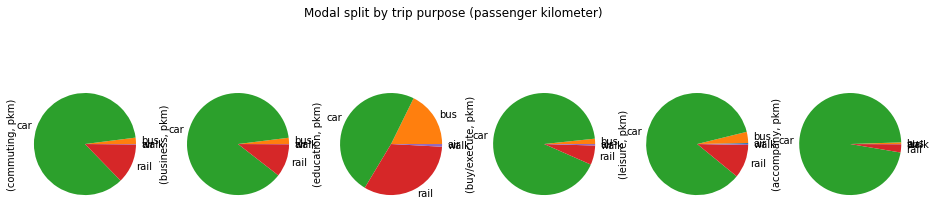

In [96]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [97]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [98]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

In [105]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])[['length']] / 1000
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [107]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True, right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left', left_index=True, right_index=True)['length'],
                        bins=bins, labels=labels)

In [110]:
p_dict = dict(zip(vp_purpose_dict.values(), vp_purpose_dict.keys()))

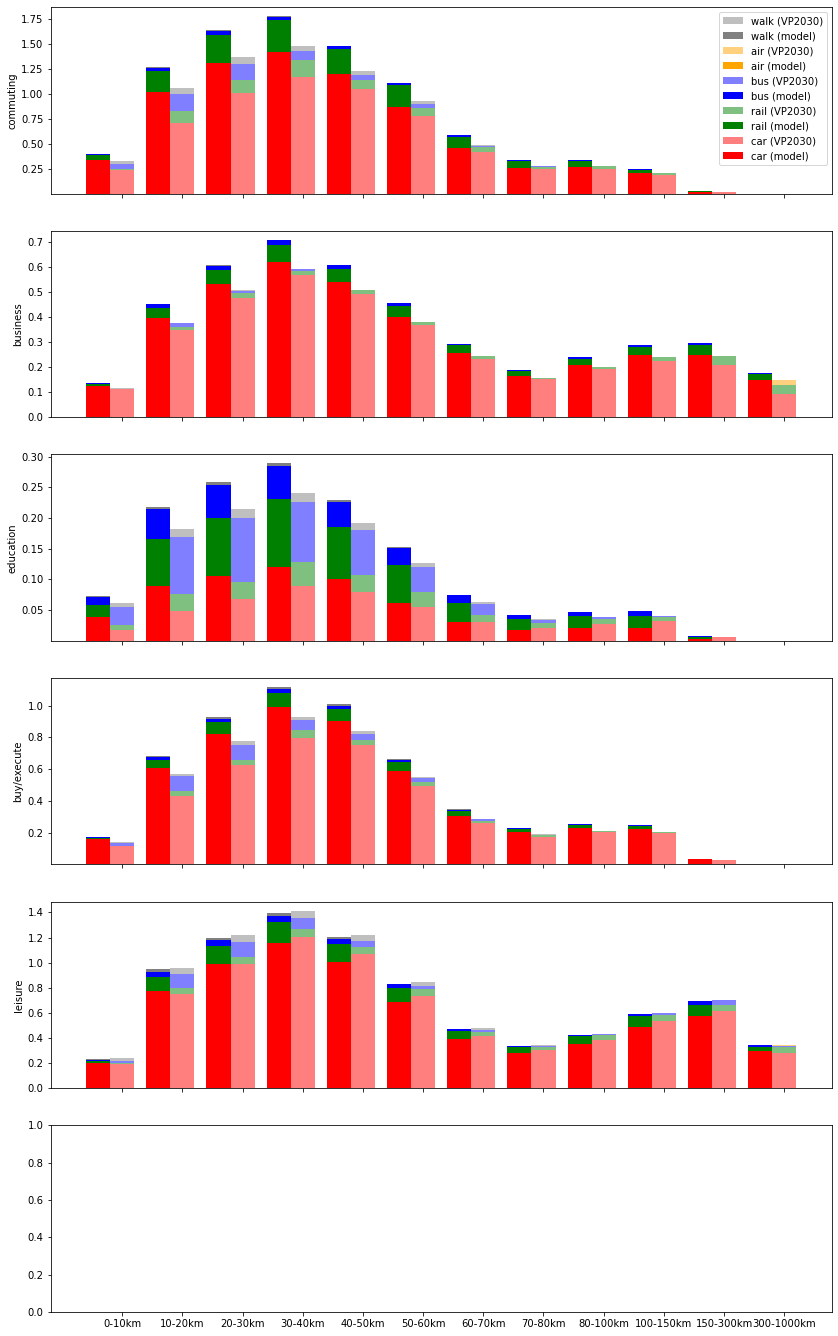

In [112]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
width = 0.4
ind = np.arange(len(labels))
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
for seg in range(len(purposes[:-1])):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    vp_vols = [vp_binned[(p_dict[purposes[seg]], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030.png', dpi=300)

In [137]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
if not str(mid2017.loc[0, 'origin']).startswith('DE'):
    lau_nuts_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
    mid2017['origin'] = mid2017['origin'].astype(str).map(lau_nuts_dict)
    mid2017['destination'] = mid2017['destination'].astype(str).map(lau_nuts_dict)
    # Drop all other trips
    mid2017 = mid2017.loc[(mid2017['origin'].notna()) & (mid2017['destination'].notna())]
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])

In [138]:
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_model']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [139]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean() / mid2017.mean().mean())

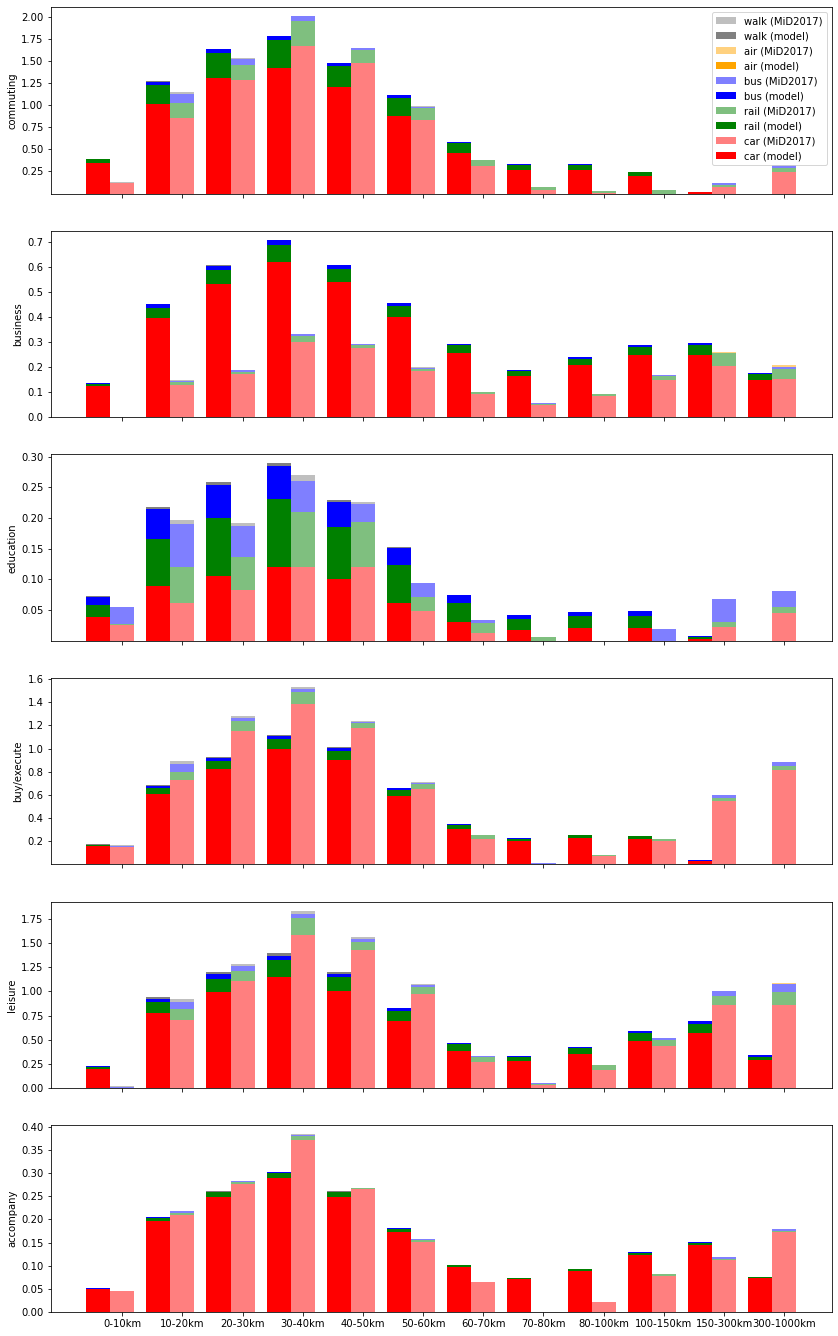

In [140]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(purposes[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=300)

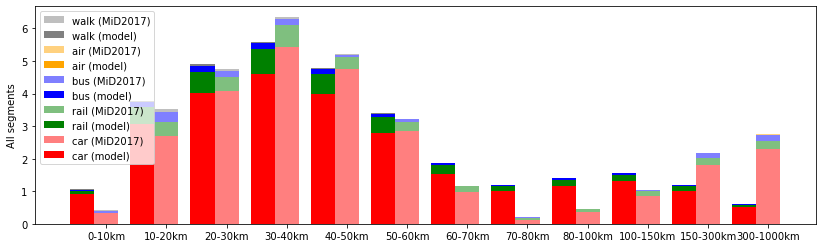

In [141]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        mid_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
ax.set_ylabel('All segments')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=300)

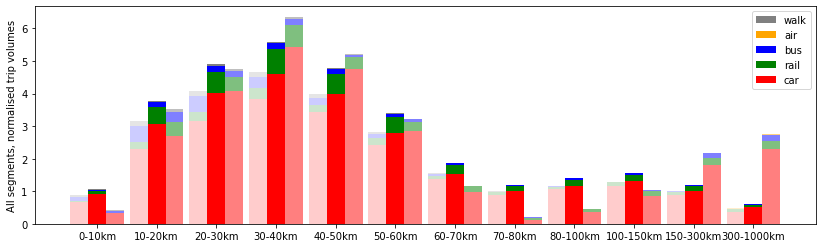

In [142]:
# Plot distance and mode distribution for all three data sources
fig, ax = plt.subplots(figsize=(14,4))
width = 0.3
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        vp_bottom = 0
        model_bottom = 0
        mid_bottom = 0
    else:
        vp_bottom = sum(vp_vols[:i])
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind-width, vp_vols[i], bottom=vp_bottom, alpha=.2,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i])#+' (model)')
ax.set_ylabel('All segments, normalised trip volumes')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-3], l[::-3])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_VP2030_all.png', dpi=300)

In [143]:
# Difference in the largest distance segment in % to MiD2017
(sum(model_vols.T[-1]) - sum(mid_vols.T[-1])) / sum(mid_vols.T[-1])

-0.7833858569147649

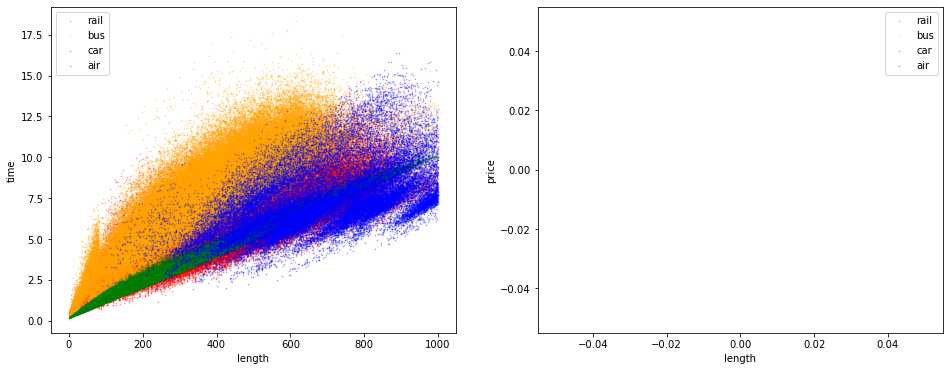

In [144]:
# How do the LoS attributes look like again?
fig, ax = plt.subplots(figsize=(8,6))
c_dict = {'rail': 'red', 'bus': 'orange', 'car': 'green', 'air': 'blue'}
sm.los['length'] = sm.los['length'] / 1000
for m in c_dict.keys():
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax, kind='scatter', x='length', y='time', s=.5, c=c_dict[m], alpha=.3, label=m)
plt.legend()
plt.savefig(output_path + scenario + '/' + 'LoS_attributes.png', dpi=300)
sm.los['length'] = sm.los['length'] * 1000

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [145]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [147]:
# Aggregated modal split in million pkm by main mode
od.groupby(level=2).sum()['pkm'] / 1e6

mode
air       1013.754762
bus      25025.866497
car     760421.713126
rail     90832.970239
walk      2219.820226
Name: pkm, dtype: float64

In [148]:
# Aggregated pkm
od.groupby(level=2).sum()['pkm'].sum() / 1e6

879514.1248512171

In [149]:
# Show pkm (mio.) by disaggregated PT modes
if 'length' not in sm.loaded_links.columns:
    sm.loaded_links['length'] = skims.distance_from_geometry(
        sm.loaded_links['geometry']).astype(int)
sm.loaded_links['pkm'] = sm.loaded_links['length']/1000 * sm.loaded_links['load']
sm.loaded_links.groupby('route_type').agg({'pkm': 'sum'}) / 1e6

,pkm
route_type,
air,739.033987
bus,12721.426591
coach,12374.708645
rail_long,25382.622712
rail_short,50938.723816


In [150]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [152]:
# Calculate weighted averages by zone aggregation
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    time=('time', weighted_av),
    in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av))

## Save model

In [153]:
with pd.ExcelWriter(output_path + scenario + '/' + 'inter_zone.xlsx') as writer:
    od.to_excel(writer, sheet_name='od')

In [154]:
sm.to_json(model_path + scenario + '/' + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [07:04<00:00, 11.18s/it]


In [61]:
# Save distances between centroids
(car.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
).astype(int).to_csv(output_path + 'distances_centroids.csv')